In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

## Random input I

In [2]:
# Make results deterministic for debugging
np.random.seed(23)

In [3]:
m = 4
n = [25, 50, 100, 250, 500, 1000, 2000]
n = 2000
A = np.random.uniform(-0.5, 1, (m, n))
pi = np.random.uniform(0, 10, n)

#b = np.ones(m)
d = 0.25
b = np.ones(m)*d*n

eps = 1/n

## offline

In [4]:
def getofflineSolution(A, pi, n, b):
    x_opt = cp.Variable(n)

    # Create constraints.
    constraints = [A @ x_opt <= b,
                   x_opt >= 0,
                   x_opt <= 1]

    # Form objective.
    obj = cp.Maximize(pi @ x_opt)

    # Form and solve problem
    prob = cp.Problem(obj, constraints)
    optObj = prob.solve()  
    return optObj

In [5]:
optObj = getofflineSolution(A, pi, n, b)

Choose eps and delta such that 
r (for DLA) and L-1 (for algorithm 2) are in the same order of magnitude to compare the two algorithms fairly.

From DLA we have:
$$l = 2^r\epsilon n \quad\text{for l < t}$$ 

if we take $\epsilon = \frac{1}{n}$ then $r = \frac{log(l)}{log(2)}$ because we have l < n then 
$$r = \bigg\lfloor \frac{log(n)}{log(2)} \bigg\rfloor$$

From Algorithm 2 we have:
$$\big\lfloor\delta^L\big\rfloor = n $$

We let r = L-1 then:

$$\Rightarrow \delta = \exp{\bigg(\frac{log(n)}{L}\bigg)} + \zeta$$

This allows r and L-1 to be similar in magnitude, facilitating a fair comparison

## DLA

In [6]:
def solveDLADual(A, pi, l, m, n, eps):
    a_up_to_t = A[:,:l]
    pi_up_to_t = pi[:l]
    p = cp.Variable(m)
    y = cp.Variable(l)

    # Create constraints.
    constraints = [np.transpose(a_up_to_t)@p + y >= pi_up_to_t,
                   p >= 0,
                   y >= 0]

    # Form objective.
    obj = cp.Minimize(((1-eps*np.sqrt(n/l))*(l/n)*b @ p+ np.ones(l)@y))
    # Form and solve problem
    prob = cp.Problem(obj, constraints)
    prob.solve()
    return p.value

In [7]:
def DLA(A, pi, m, n, b):
    ## formulate as dual P and solved

    x = np.zeros(n)
    eps = 1/n
    t0 = int(eps*n)

    #p = constraints[0].dual_value
    p_hat = solveDLADual(A, pi, t0, m, n, eps)

    r_current = 0
    l_current = 0
    for t in range(t0+1,n):
        r = np.floor(np.log(t) / np.log(2))

        if r <= r_current:
            x_hat = pi[t] > p_hat @ A[:,t]
        else:
            r_current = r
            l_current = int((2**r_current)*eps*n) 
            # fields

            #p = constraints[0].dual_value
            p_hat = solveDLADual(A, pi, l_current, m, n, eps)
            x_hat = pi[t] > p_hat @ A[:,t]

        if np.all(A[:,t] * int(x_hat) <= b - A[:,:t]@x[:t]):
            x[t] = int(x_hat)

    return pi@x

In [8]:
optObj - DLA(A, pi, m, n, b)

60.09227193339393

## Alg 2

In [9]:
def Alg2(A, pi, m, n, d):
    L = int(np.floor(np.log(n)/np.log(2))+1)
    delta = np.exp(np.log(n)/L) + 1e-6

    x = np.zeros(n)
    for k in range(1,L):
        t_k = int(np.floor(delta**k))
        a_up_to_t = A[:,:t_k]
        pi_up_to_t = pi[:t_k]

        x_opt = cp.Variable(t_k)

        # Create constraints.
        constraints = [a_up_to_t @ x_opt <= t_k*d,
                   x_opt >= 0,
                   x_opt <= 1]
        # Form objective.
        obj = cp.Maximize(pi_up_to_t @ x_opt)

        # Form and solve problem
        prob = cp.Problem(obj, constraints)
        prob.solve()
        p = constraints[0].dual_value
        for t in range(t_k+1, int(np.floor(delta**(k+1)))+1):
            if  t==n:
                return pi@x
            x_hat = pi[t] > np.transpose(A[:,t])@p
            if np.all(A[:,t] * int(x_hat) <= b - A[:,:t]@x[:t]):
                x[t] = int(x_hat)

    return pi@x

In [10]:
optObj - Alg2(A, pi, m, n, d)

60.09227193339393

## Analyses

In [11]:
np.random.seed(101)

In [12]:
DLA_regret_res = dict()
Alg2_regret_res = dict()
DLA_remaining_resources = dict()
Alg2_remaining_resources = dict()


In [13]:
from tqdm import tqdm

In [14]:
m = 4
ns = [25, 50, 100, 250, 500, 1000, 2000]
#ns = 100
b = np.ones(m)
n_samples = 100
for n in tqdm(ns):
    eps = 1/n
    DLA_regret = []
    Alg2_regret = []
    DLA_resources = []
    Alg2_resources = []
    for sim in range(n_samples):
        A = np.random.uniform(-0.5, 1, (m, n))
        pi = np.random.uniform(0, 10, n)
        #d = b/n
        d = np.ones(m) * 0.25
        b = d*n
        optObj = getofflineSolution(A, pi, n, b)
        DLA_opt = DLA(A, pi, m, n, b)
        Alg2_opt = Alg2(A, pi, m, n, d)
        
        DLA_regret.append(optObj - DLA_opt)
        Alg2_regret.append(optObj - Alg2_opt)
        
    DLA_regret_res[n] = DLA_regret
    Alg2_regret_res[n] = Alg2_regret 
    

100%|██████████| 7/7 [01:39<00:00, 14.28s/it]


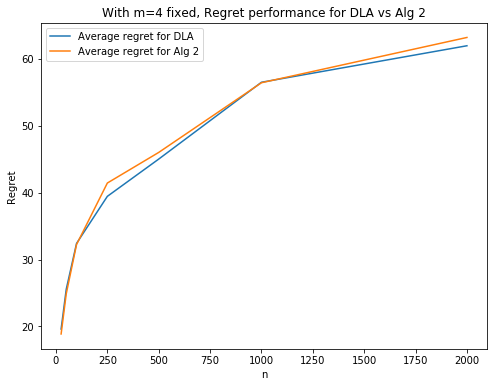

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
line1, = ax.plot(list(DLA_regret_res.keys()), list(([np.mean(DLA_regret_res[k]) for k in DLA_regret_res.keys()])), label = 'Average regret for DLA')
line2, = ax.plot(list(Alg2_regret_res.keys()), list(([np.mean(Alg2_regret_res[k]) for k in Alg2_regret_res.keys()])), label = 'Average regret for Alg 2')
ax.legend(handles=[line1, line2])
plt.xlabel("n")
plt.ylabel("Regret")
plt.title("With m=%d fixed, Regret performance for DLA vs Alg 2" % (m))
plt.savefig("DLARegret")
plt.show()
